# Linear Regression in Statsmodels
- Steven Phillips
- January 19, 2023

Task: Run a linear regression with statsmodels and predict the price of a car.

## Steps to Perform:

    - Perform initial preprocessing of data
    - Perform preprocessing for statsmodels
    - Run the model in statsmodels and produce a results summary
    - Evaluate the model on the test set

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# fixing random for lesson generation
np.random.seed(321)

# Standard Statsmodels import
import statsmodels.api as sm

### Initial preprocessing of data

In [2]:
# Load in the car dataset and display the head and info
df = pd.read_csv('/Users/steve/Documents/GitHub/Linear-Regression-in-statsmodels/Data/CarPrice_Assignment.csv')
display(df.head(),df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


None

In [3]:
# copy the dataframe
df_cars = df.copy()

In [4]:
# check for duplicate rows
df_cars.duplicated().sum()

0

In [5]:
# check for unique values by feature
df.nunique()

car_ID              205
symboling             6
CarName             147
fueltype              2
aspiration            2
doornumber            2
carbody               5
drivewheel            3
enginelocation        2
wheelbase            53
carlength            75
carwidth             44
carheight            49
curbweight          171
enginetype            7
cylindernumber        7
enginesize           44
fuelsystem            8
boreratio            38
stroke               37
compressionratio     32
horsepower           59
peakrpm              23
citympg              29
highwaympg           30
price               189
dtype: int64

In [6]:
# drop car_ID and CarName

df_cars = df_cars.drop(columns = ['car_ID', 'CarName'])
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    object 
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

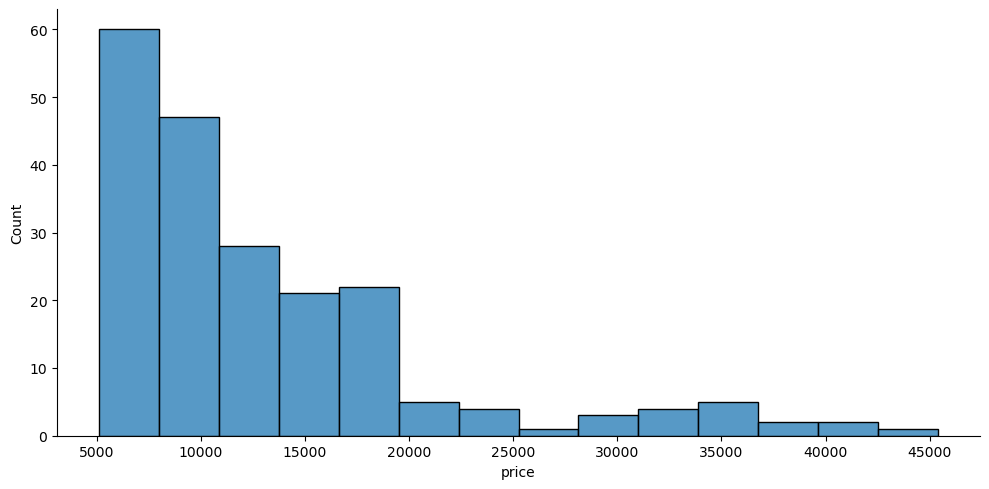

In [7]:
# Visualize the distribution of car prices (using seaborn!)
sns.displot(df_cars['price'],aspect=2);

### Preprocessing for statsmodels

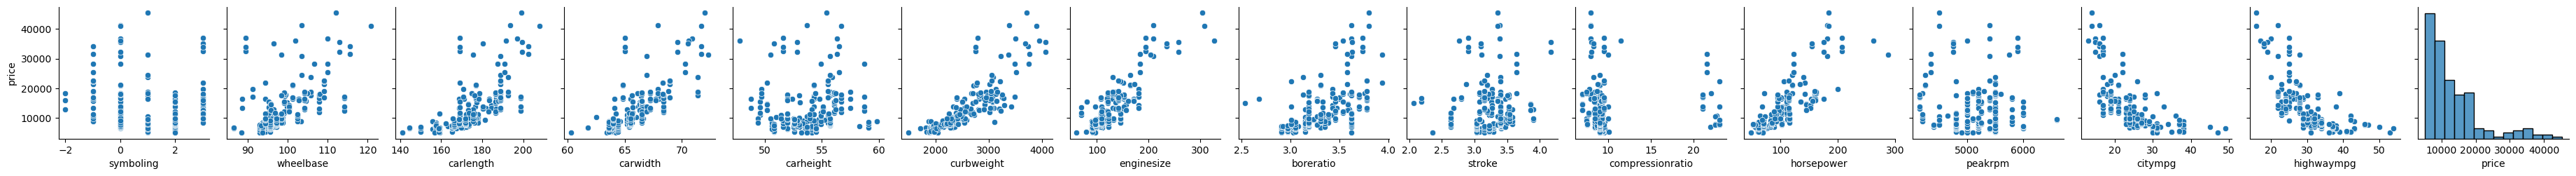

In [8]:
## Quick EDA for cols related to target
sns.pairplot(df_cars,y_vars='price');

We want to determine how features of a car influence its sale price.

Specifically, we will be using:

- wheelbase
- carheight
- compression ratio
- horsepower
- carbody

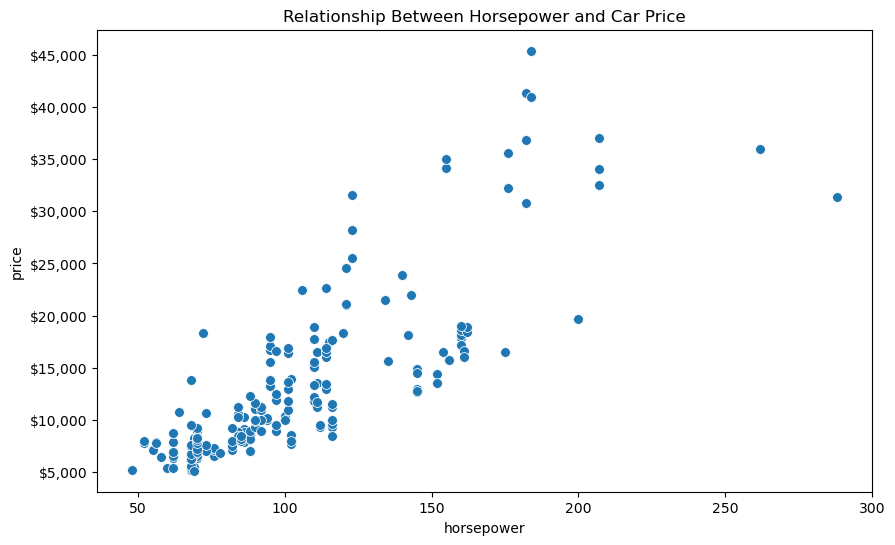

In [9]:
from matplotlib.ticker import StrMethodFormatter
# Plot a scatter plot of horsepower vs price
ax = sns.scatterplot(data=df_cars,x='horsepower',y='price',s=50)
ax.set_title('Relationship Between Horsepower and Car Price')

# Formatting Price Axis
price_fmt = StrMethodFormatter("${x:,.0f}")
ax.yaxis.set_major_formatter(price_fmt)
ax.get_figure().set_size_inches(10,6)

In [10]:
def plot_feature_vs_target(df_cars,x='horsepower',y='price',price_format=True):
    """Plots a seaborn regplot of x vs y."""
    ax = sns.regplot(data=df_cars,x=x,y=y,
                line_kws=dict(color='k',ls='--',lw=2),
               scatter_kws=dict(s=50,edgecolor='white',lw=1,alpha=0.8)
                    )
    
    ax.get_figure().set_size_inches(10,6)
    ax.set_title(f'{x} vs {y}')
    ax.get_figure().set_facecolor('white')
    
    if price_format:
        ## Formatting Price Axis
        price_fmt = StrMethodFormatter("${x:,.0f}")
        ax.yaxis.set_major_formatter(price_fmt)
    return ax

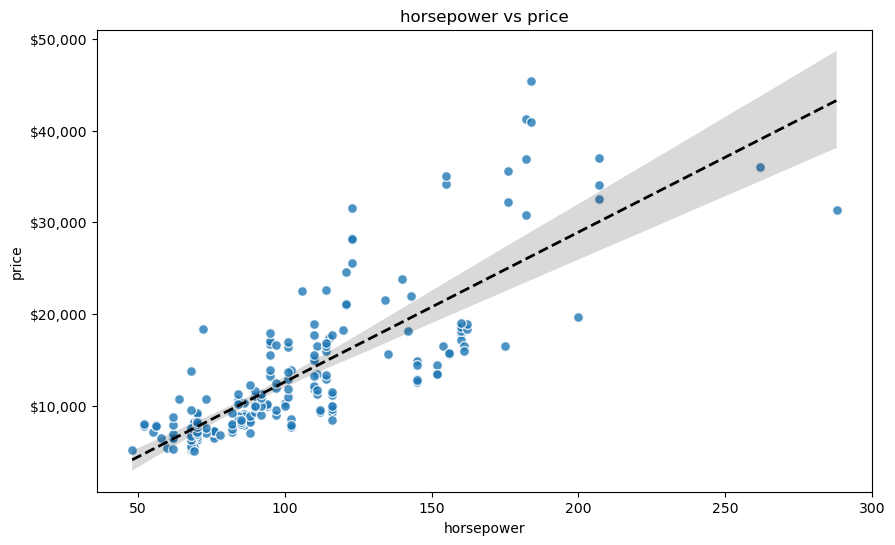

In [11]:
# Visualize the relationship between horsepower and price
ax = plot_feature_vs_target(df_cars,x='horsepower');

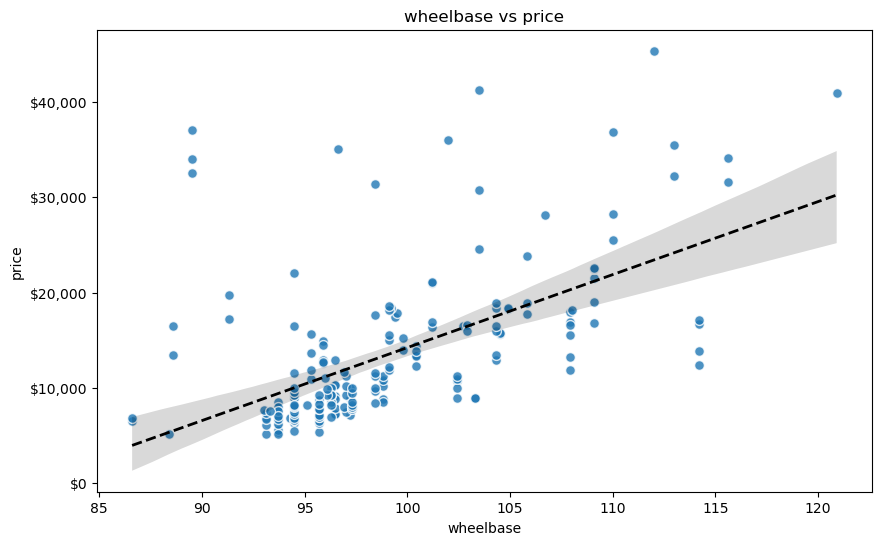

In [12]:
# Visualize the relationship between wheelbase and price
ax = plot_feature_vs_target(df_cars,x='wheelbase');

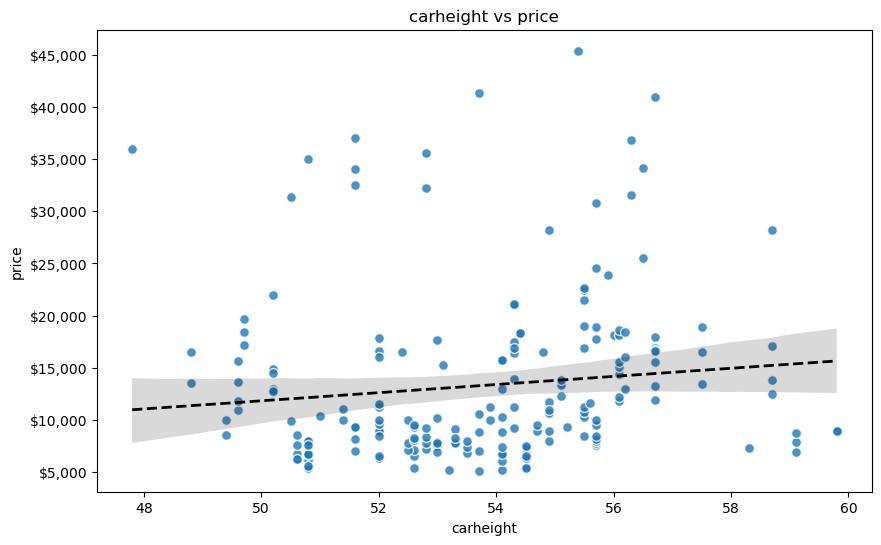

In [13]:
# Visualize the relationship between carheight and price
ax = plot_feature_vs_target(df_cars,x='carheight');

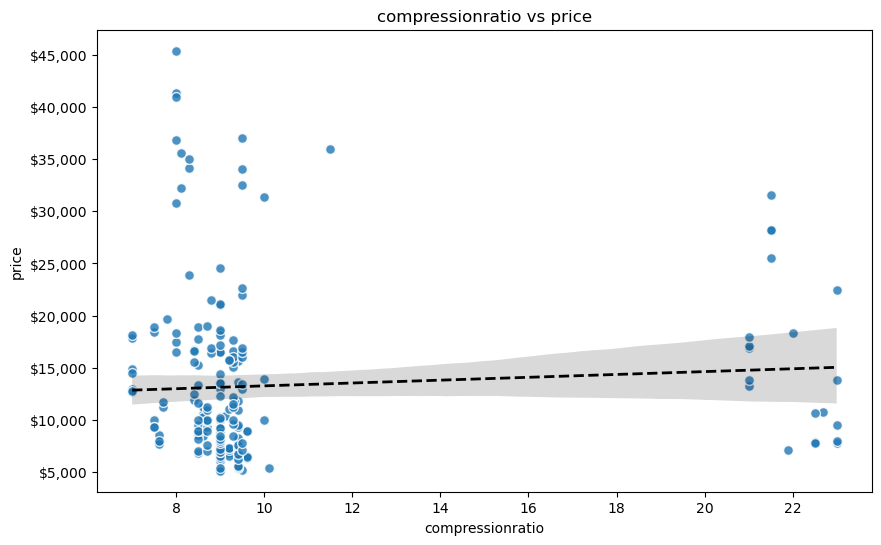

In [14]:
# Visualize the relationship between compression ratio and price
ax = plot_feature_vs_target(df_cars,x='compressionratio');

In [15]:
# Create our X & y using wheelbase, car height, compression ratio, and horsepower
use_cols = ['carbody','wheelbase','carheight','compressionratio', 'horsepower']
X = df[use_cols].copy()
y = df['price'].copy()

## Train test split (random-state 321, test_size=0.25)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=321)
X_train

,carbody,wheelbase,carheight,compressionratio,horsepower
17,sedan,110.0,56.3,8.0,182
39,sedan,96.5,54.1,9.0,86
40,sedan,96.5,54.1,9.0,86
47,sedan,113.0,52.8,8.1,176
123,wagon,103.3,59.8,8.5,88
...,...,...,...,...,...
200,sedan,109.1,55.5,9.5,114
41,sedan,96.5,54.1,9.0,101
31,hatchback,86.6,50.8,9.2,76
124,hatchback,95.9,50.2,7.0,145


In [16]:
# make cat selector and use it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['carbody']

In [17]:
# make num selector and use it to save list of column names

num_select = make_column_selector(dtype_include = 'number')
num_cols = num_select(X_train)
num_cols

['wheelbase', 'carheight', 'compressionratio', 'horsepower']

In [18]:
# make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),# not using StandardScaler()
                        )
preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols), remainder='passthrough')

In [19]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['carbody']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['wheelbase', 'carheight', 'compressionratio',
                                  'horsepower'])])

In [20]:
pd.DataFrame(preprocessor.transform(X_train).round(3))

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,1.0,0.0,110.0,56.3,8.0,182.0
1,0.0,0.0,0.0,1.0,0.0,96.5,54.1,9.0,86.0
2,0.0,0.0,0.0,1.0,0.0,96.5,54.1,9.0,86.0
3,0.0,0.0,0.0,1.0,0.0,113.0,52.8,8.1,176.0
4,0.0,0.0,0.0,0.0,1.0,103.3,59.8,8.5,88.0
...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.0,1.0,0.0,109.1,55.5,9.5,114.0
149,0.0,0.0,0.0,1.0,0.0,96.5,54.1,9.0,101.0
150,0.0,0.0,1.0,0.0,0.0,86.6,50.8,9.2,76.0
151,0.0,0.0,1.0,0.0,0.0,95.9,50.2,7.0,145.0


In [21]:
# create an empty features list
final_features = []

In [22]:
# find the categorical pipeline in col transformer
preprocessor.named_transformers_['pipeline-1']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [23]:
# slice out the name of the onject
preprocessor.named_transformers_['pipeline-1'].named_steps

{'simpleimputer': SimpleImputer(fill_value='MISSING', strategy='constant'),
 'onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False)}

In [25]:
ohe_step = preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder']
ohe_step

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [26]:
# get OHE feature names
cat_features = ohe_step.get_feature_names_out(cat_cols)
cat_features

array(['carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon'], dtype=object)

In [27]:
# add categorical feature names to final_features list
final_features.extend(cat_features)
final_features

['carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon']

In [28]:
# confirm num features
num_cols

['wheelbase', 'carheight', 'compressionratio', 'horsepower']

In [29]:
# add numeric features passed through model
final_features.extend(num_cols)
final_features

['carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'wheelbase',
 'carheight',
 'compressionratio',
 'horsepower']

#### Remaking the train and test data frames

In [30]:
X_train_df = pd.DataFrame( preprocessor.transform(X_train), columns=final_features, index=X_train.index)
X_train_df.head()

,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,wheelbase,carheight,compressionratio,horsepower
17,0.0,0.0,0.0,1.0,0.0,110.0,56.3,8.0,182.0
39,0.0,0.0,0.0,1.0,0.0,96.5,54.1,9.0,86.0
40,0.0,0.0,0.0,1.0,0.0,96.5,54.1,9.0,86.0
47,0.0,0.0,0.0,1.0,0.0,113.0,52.8,8.1,176.0
123,0.0,0.0,0.0,0.0,1.0,103.3,59.8,8.5,88.0


In [31]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=final_features, index=X_test.index)
X_test_df.head()

,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,wheelbase,carheight,compressionratio,horsepower
48,0.0,0.0,0.0,1.0,0.0,113.0,52.8,8.1,176.0
196,0.0,0.0,0.0,1.0,0.0,104.3,56.2,9.5,114.0
148,0.0,0.0,0.0,0.0,1.0,96.9,54.9,9.0,82.0
53,0.0,0.0,0.0,1.0,0.0,93.1,54.1,9.0,68.0
99,0.0,0.0,1.0,0.0,0.0,97.2,54.7,8.5,97.0


In [32]:
# Overwrite existing data frames to include a constant
X_train_df = sm.add_constant(X_train_df,has_constant='add', prepend=False)
X_test_df = sm.add_constant(X_test_df,has_constant='add', prepend=False)
display(X_train_df.head(2), X_test_df.head(2))

,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,wheelbase,carheight,compressionratio,horsepower,const
17,0.0,0.0,0.0,1.0,0.0,110.0,56.3,8.0,182.0,1.0
39,0.0,0.0,0.0,1.0,0.0,96.5,54.1,9.0,86.0,1.0


,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,wheelbase,carheight,compressionratio,horsepower,const
48,0.0,0.0,0.0,1.0,0.0,113.0,52.8,8.1,176.0,1.0
196,0.0,0.0,0.0,1.0,0.0,104.3,56.2,9.5,114.0,1.0


###  Run the model in statsmodels and produce a results summary

In [33]:
# instantiate an OLS model WITH the training data.

model = sm.OLS(y_train, X_train_df, hasconst=True)

In [34]:
# Fitting the model 
result = model.fit()

In [35]:
# get model performance metrics
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     67.78
Date:                Fri, 20 Jan 2023   Prob (F-statistic):           5.07e-45
Time:                        10:12:41   Log-Likelihood:                -1466.3
No. Observations:                 153   AIC:                             2951.
Df Residuals:                     144   BIC:                             2978.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
carbody_convertible -2026.5826   1860.313     -1.089      0.278   -5703.632    1650.467
carbody_hardtop     -7074.6686   2051.689     -3.448      0.001   -1.11e+04   -3019.351
carbody_hatchback   -1.103e+04   1348.743     -8.178      0.000   -1.37e+04   -8363.720
carbody_sedan       -1.016e+04   1662.134     -6.114      0.000   -1.34e+04   -6876.176
carbody_wagon       -1.251e+04   2134.039     -5.864      0.000   -1.67e+04   -8295.390
wheelbase             552.8538     86.733      6.374      0.000     381.419     724.288
carheight             -35.1214    191.556     -0.183      0.855    -413.746     343.503
compressionratio      137.8209     79.789      1.727      0.086     -19.889     295.530
horsepower            117.1912     10.801     10.850      0.000      95.842     138.540
const               -4.281e+04   7226.782     -5.923      0.000   -5.71e+04   -2.85e+04
==============================================================================
Omnibus:                       39.578   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.752
Skew:                           1.046   Prob(JB):                     1.32e-22
Kurtosis:                       6.381   Cond. No.                     2.67e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.23e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

###  Evaluate the model on the test set

In [36]:
# Fit an OLS model
model = sm.OLS(y_train,X_train_df)
result = model.fit()
# Use the result (not the model) to .predict
test_preds = result.predict(X_test_df)

In [37]:
# use the sklearn metrics on the test set

test_r2 = r2_score(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

In [38]:
print(f'The testing r-square value is {test_r2:.3f} and the testing mean squared error is {test_mse:.3f}.')

The testing r-square value is 0.829 and the testing mean squared error is 13057048.596.
